# Uncertainty in Computer Vision

## Deep Ensemble

This notebook contains an implementation of the Deep Ensemble model - a collection of convolutional neural networks (LeNet), trained with random weight initialisation. Their softmax-scaled predictions are averaged for the final prediction.

**This notebook is meant for demonstration purposes and does not include optimal training parameters**

_Author: Domantas Giržadas, 2022_

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

# For SSL certificate error during dataset download
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
# Setting up the cuda device for performing computations on a GPU
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
    print(f"Current device: {torch.cuda.get_device_name(device)}")
else:
    device = torch.device("cpu")
    print(f"Current device: CPU")

Current device: NVIDIA GeForce RTX 3080


In [3]:
# Initialising the dataset loaders for training and test sets

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='data/', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=5,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='data/', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=5,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def imshow(img):
    """
    Function for visualising the images from the CIFAR-10 dataset
    """
    img = img / 2 + 0.5     # (unnormalizing)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

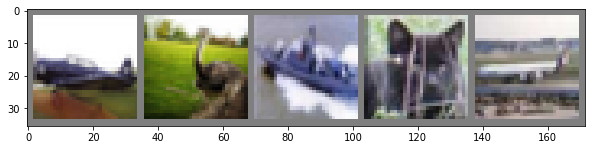

        plane          bird          ship           cat         plane


In [5]:
# Getting a batch of images from the dataset and visualising them
dataiter = iter(trainloader)
images, labels = dataiter.next()

plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
# Print image labels
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

# Deep Ensemble

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

ens_size = 10 # Number of ensemble members

# Initialising the CNN
class LeNet_ens(nn.Module):
    def __init__(self):
        super(LeNet_ens, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialising an ensemble of networks
nets = [LeNet_ens().to(device) for _ in range(ens_size)]

## Training

In [7]:
# Initialising the training parameters
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

max_iteration = len(trainloader) * 20
lambda_poly = lambda iteration: pow((1.0 - iteration / max_iteration), 0.9)

optimizers = [optim.Adam(nets[i].parameters()) for i in range(ens_size)]
schedulers = [torch.optim.lr_scheduler.LambdaLR(optimizers[i], lr_lambda=lambda_poly) for i in range(ens_size)]

In [8]:
# Model training
for epoch in range(20):  # loop over the dataset 20 times
    running_losses = [0.0 for _ in range(ens_size)]
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        for ens_id in range(ens_size):
            # zero the parameter gradients
            optimizers[ens_id].zero_grad()

            # forward + backward + optimize
            outputs = nets[ens_id](inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizers[ens_id].step()
            schedulers[ens_id].step()

            # print statistics
            running_losses[ens_id] += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] losses:' %(epoch + 1, i + 1))
            print(np.array(running_losses) / 2000)
            running_losses = [0.0 for _ in range(ens_size)]

print('Finished Training')

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] losses:
[1.835278   1.82114487 1.83530995 1.79477371 1.83928954 1.79768824
 1.86726288 1.82289351 1.79138371 1.80409294]
[1,  4000] losses:
[1.5418209  1.54016304 1.53645448 1.5296799  1.53791699 1.5382005
 1.52412882 1.55246642 1.52130188 1.53412901]
[1,  6000] losses:
[1.44722529 1.48566382 1.47303452 1.47253881 1.45559061 1.48103818
 1.44839114 1.49248718 1.44322927 1.49040141]
[1,  8000] losses:
[1.39309889 1.42184939 1.43442767 1.43635265 1.39334279 1.43253681
 1.39894594 1.43590456 1.40032858 1.43588569]
[1, 10000] losses:
[1.34614634 1.38212318 1.3917615  1.39110225 1.33984526 1.39378305
 1.34669633 1.39392925 1.34507676 1.41161908]
[2,  2000] losses:
[1.2625506  1.29277685 1.30100683 1.30455934 1.24959873 1.30413409
 1.26278107 1.30377524 1.25688806 1.32847001]
[2,  4000] losses:
[1.23246626 1.27650346 1.28535042 1.28938692 1.22869331 1.2682619
 1.25638951 1.29049884 1.2472834  1.32205711]
[2,  6000] losses:
[1.21983731 1.26496406 1.27984747 1.28359232 1.24354301 1.2

[13,  6000] losses:
[0.67340479 0.62321998 0.69524434 0.64428541 0.63838217 0.66510134
 0.73605689 0.68060747 0.6393497  0.6862742 ]
[13,  8000] losses:
[0.6742875  0.6193532  0.72015356 0.65836317 0.63062721 0.65493532
 0.71731372 0.69048449 0.64738587 0.66873472]
[13, 10000] losses:
[0.66881164 0.62646439 0.68652929 0.66033625 0.64585744 0.6720947
 0.72447855 0.68154484 0.65293234 0.69350397]
[14,  2000] losses:
[0.60248079 0.54950406 0.64362024 0.57776363 0.56711198 0.59016608
 0.67046102 0.6171075  0.57671868 0.60765357]
[14,  4000] losses:
[0.6061569  0.54705033 0.63498207 0.58315974 0.57396339 0.59556569
 0.66084597 0.61841803 0.58207782 0.6082683 ]
[14,  6000] losses:
[0.6254011  0.58079156 0.67548688 0.60472993 0.59161792 0.62047667
 0.69173587 0.64507329 0.60349882 0.64141378]
[14,  8000] losses:
[0.64155964 0.59269183 0.65499569 0.60331681 0.60231916 0.62908573
 0.69183482 0.64649583 0.60087468 0.64616038]
[14, 10000] losses:
[0.64476469 0.58367615 0.68916339 0.61528824 0.616

In [9]:
# Optionally, save the ensemble of models to a .pt file
for i in range(ens_size):
    torch.save(nets[i], f"model-ens-{i}.pt")

## Evaluation

In [6]:
nets = [torch.load(f"model-ens-{i}.pt") for i in range(ens_size)]

In [7]:
def aggregate_ens_predictions(models, inputs):
    """
    A function that aggregates individual predictions of the ensemble members and returns the average
    """
    preds = []
    for model in models:
        preds.append(F.softmax(model(inputs)).cpu().detach().numpy())
    return np.array(preds).mean(axis = 0)

In [8]:
# Evaluate training and validation accuracy

train_hits = []
test_hits = []

for i, data in enumerate(trainloader):
    print(f"Training set... \t{i+1} / {len(trainloader)}", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_ens = aggregate_ens_predictions(nets, inputs)

    train_hits.extend(np.array(np.argmax(pred_ens, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')

for i, data in enumerate(testloader):
    print(f"Validation set... \t{i+1} / {len(testloader)}\t", end = '\r')
    inputs, labels = data
    inputs = inputs.to(device)
    pred_ens = aggregate_ens_predictions(nets, inputs)

    test_hits.extend(np.array(np.argmax(pred_ens, axis = 1)) == np.array(labels))
    
print("                               ",end='\r')
print(f"Training accuracy: {np.mean(train_hits)*100:.3f}%")
print(f"Validation accuracy: {np.mean(test_hits)*100:.3f}%")

D:\Anaconda\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-7-bc5c4ef208ba>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.append(F.softmax(model(inputs)).cpu().detach().numpy())


Training accuracy: 95.874%     
Validation accuracy: 74.860%


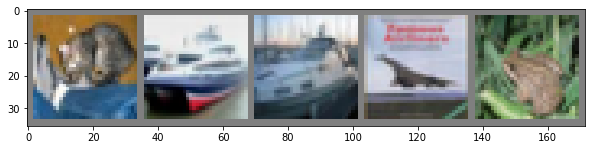

          cat          ship          ship         plane          frog


<ipython-input-7-bc5c4ef208ba>:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  preds.append(F.softmax(model(inputs)).cpu().detach().numpy())


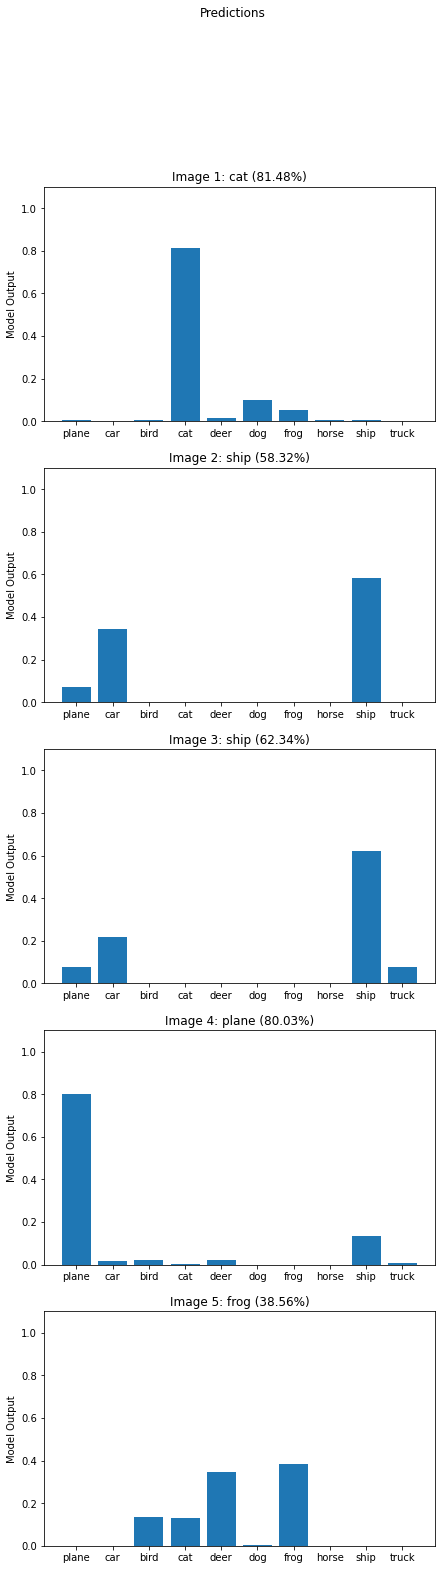

In [9]:
# Predict a batch of validation images and visualise the model output
dataiter = iter(testloader)

images, labels = dataiter.next()
plt.figure(figsize=(10,5))
imshow(torchvision.utils.make_grid(images))
print(' '.join('%13s' % classes[labels[j]] for j in range(len(images))))

images = images.to(device)
net_outputs = aggregate_ens_predictions(nets, images)

fig, axs = plt.subplots(len(images), 1, figsize=(7,25))
plt.setp(axs, xticks=np.arange(10), xticklabels=classes, ylim=(0,1.1), ylabel="Model Output")
fig.suptitle('Predictions')

for i in range(len(images)):
    axs[i].bar(np.arange(10), np.array(net_outputs[i]))
    axs[i].set_title(f"Image {i+1}: {classes[np.argmax(net_outputs[i])]} ({net_outputs[i].max()*100:.2f}%)")
plt.show()